In [1]:
import numpy as np
import pandas as pd

from keras.datasets import mnist

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
%matplotlib inline

- データセットのダウンロード

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

- データセットの確認

In [3]:
print(X_train.shape) # (60000, 28, 28)
print(X_test.shape) # (10000, 28, 28)
print(X_train[0].dtype) # uint8
print(X_train[0])

(60000, 28, 28)
(10000, 28, 28)
uint8
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3  18  18  18 126 136
  175  26 166 255 247 127   0   0   0   0]
 [  0   0   0   0   0   0   0   0  30  36  94 154 170 253 253 253 253 253
  225 172 253 242 195  64   0   0   0   0]
 [  0   0   0   0   0   0   0  49 238 253 253 253 253 253 253 253 253 251
   93  82  82  56  39   0   0   0   0   0]
 [  0   0   0   0   0   0 

- 平滑化

In [4]:
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

In [5]:
X_train.shape, X_test.shape

((60000, 784), (10000, 784))

- 画像データの可視化

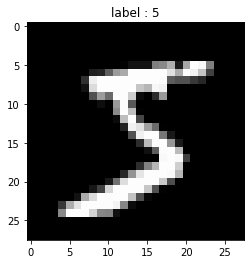

In [6]:
index = 0
image = X_train[index].reshape(28,28)
# X_train[index]: (784,)
# image: (28, 28)
plt.imshow(image, 'gray')
plt.title('label : {}'.format(y_train[index]))
plt.show()

- 前処理

In [7]:
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255

print(X_train.max()) # 1.0
print(X_train.min()) # 0.0

1.0
0.0


In [8]:
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])

print(y_train.shape) # (60000,)
print(y_train_one_hot.shape) # (60000, 10)
print(y_train_one_hot.dtype) # float64

(60000,)
(60000, 10)
float64


In [9]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train_one_hot, test_size=0.2)

print(X_train.shape, y_train.shape) # (48000, 784)
print(X_val.shape, y_val.shape) # (12000, 784)

(48000, 784) (48000, 10)
(12000, 784) (12000, 10)


In [10]:
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
        
    def __len__(self):
        return self._stop
    
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]     
    
    def __iter__(self):
        self._counter = 0
        return self
    
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

In [11]:
class ScratchSimpleNeuralNetrowkClassifier():
    """
    シンプルな三層ニューラルネットワーク分類器

    Parameters
    ----------
    activation : str
        活性化関数：sigmoid(シグモイド関数) or tanh(ハイパボリックタンジェント関数)
    n_nodes1 : int
        1層目のノード数
    n_nodes2 : int
        2層目のノード数
    n_output : int
        出力のクラス数

    Attributes
    ----------
    self.W1 : 次の形のndarray, shape (self.n_features, self.n_nodes1)
        1層目の重み
    self.B1 : 次の形のndarray, shape (self.n_nodes1)
        1層目のバイアス
    self.W2 : 次の形のndarray, shape (self.n_nodes1, self.n_nodes2)
        2層目の重み
    self.B2 : 次の形のndarray, shape (self.n_nodes2)
        2層目のバイアス
    self.W3 : 次の形のndarray, shape (self.n_nodes2, self.n_output)
        3層目の重み
    self.B3 : 次の形のndarray, shape (self.n_output)
        3層目のバイアス
    self.A1 : 次の形のndarray, shape (self.batch_size, self.n_nodes1)
        1層目の線形結合の値
    self.Z1 : 次の形のndarray, shape (self.batch_size, self.n_nodes1)
        1層目の活性化関数の線形変換による値
    self.A2 : 次の形のndarray, shape (self.batch_size, self.n_nodes2)
        2層目の線形結合の値
    self.Z2 : 次の形のndarray, shape (self.batch_size, self.n_nodes2)
        2層目の活性化関数の線形変換による値
    self.epochs : int
        エポック数(初期値：10)
    self.batch_size : int
        バッチサイズ(初期値：20)
    self.n_features : int
        特徴量の数
    self.val_is_true : boolean
        検証用データの有無    
    self.loss : 空のndarray
        訓練データに対する損失の記録
    self.loss_val : 空のndarray
        検証データに対する損失の記録
    """
    def __init__(self, activation, n_nodes1, n_nodes2, n_output):
        self.activation = activation      # 活性化関数     
        self.n_nodes1 = n_nodes1      # 1層目のノード数
        self.n_nodes2 = n_nodes2      # 2層目のノード数
        self.n_output = n_output        # 出力のクラス数（10 : 3層目のノード数）        
        
    # 問題 1
    def __initialize_weights(self):
        """
        重みを初期化する関数
        """
        sigma = 0.01 # ガウス分布の標準偏差
        
        self.W1 = sigma * np.random.randn(self.n_features, self.n_nodes1)
        self.B1 = sigma * np.random.randn(self.n_nodes1)
        
        self.W2 = sigma * np.random.randn(self.n_nodes1, self.n_nodes2)
        self.B2 = sigma * np.random.randn(self.n_nodes2)
        
        self.W3 = sigma * np.random.randn(self.n_nodes2, self.n_output)
        self.B3 = sigma * np.random.randn(self.n_output)
    
    def __forward_propagation(self, X):
        """
        フォワードプロバゲーション
        """
        # 1層目
        self.A1 = np.dot(X, self.W1) + self.B1        
        self.Z1 = self.__activation_function(self.A1)
        
        # 2層目
        self.A2 = np.dot(self.Z1, self.W2) + self.B2        
        self.Z2 = self.__activation_function(self.A2)           
        
        # 3層目
        A3 = np.dot(self.Z2, self.W3) + self.B3

        return self.__softmax_function(A3)
    
    def __activation_function(self, A):
        """
        活性化関数 :
        シグモイド関数    
        ハイパボリックタンジェント関数
        """
        if self.activation == 'sigmoid':           
            return 1 / (1 + np.exp(-A))
        elif self.activation == 'tanh':            
            return np.tanh(A)   
        else:
            raise NameError("name \"" + str(self.activation) + "\" is not defined. set either \"sigmoid\" or \"tanh\" .") 
            
    def __sigmoid_function(self, X):
        """
        シグモイド関数にて仮定関数を計算
        課題提出用にコードを残している
        """
        return 1 / (1 + np.exp(-X))
    
    def __hyperbolic_tangent_function(self, X):
        """
        ハイパボリックタンジェント関数にて仮定関数を計算
        課題提出用にコードを残している
        (np.exp(X) - np.exp(-X)) / (np.exp(X) + np.exp(-X))
        """        
        return np.tanh(X)

    def __softmax_function(self, A):
        """
        ソフトマックス関数にて各クラスに属する確率を計算
        合計値: 1.0
        """        
        return np.exp(A) / np.sum(np.exp(A), axis=1, keepdims=True)
    
    # 問題 3
    def __cross_entropy_error(self, y, z):
        """
        交差エントロピー誤差で目的関数を計算する関数
        """
        batch_size = y.shape[0]

        return -np.sum(y * np.log(z)) / batch_size

    def __backpropagation(self):
        """
        バックプロパゲーション
        """
        # 3層目
        partial_A3 = self.Z3 - self.y_

        partial_B3 = np.sum(partial_A3, axis=0)     
        partial_W3 = np.dot(self.Z2.T,  partial_A3)
        partial_Z2 = np.dot(partial_A3, self.W3.T)         

        self.W3, self.B3 = self.__stochastic_gradient_descent(self.W3, partial_W3, self.B3, partial_B3) # W3とB3の重みの更新値        

        # 2層目
        partial_A2 = self.__derivative_function(self.A2, partial_Z2)

        partial_B2 = np.sum(partial_A2, axis=0)
        partial_W2 = np.dot(self.Z1.T,  partial_A2)    
        partial_Z1 = np.dot(partial_A2, self.W2.T)         

        self.W2, self.B2 = self.__stochastic_gradient_descent(self.W2, partial_W2, self.B2, partial_B2) # W2とB2の重みの更新値

        # 1層目
        partial_A1 = self.__derivative_function(self.A1, partial_Z1)

        partial_B1 = np.sum(partial_A1, axis=0)
        partial_W1 = np.dot(self.X_.T,  partial_A1)
        
        self.W1, self.B1 = self.__stochastic_gradient_descent(self.W1, partial_W1, self.B1, partial_B1) # W1とB1の重みの更新値
 
    def __derivative_function(self, A, Z):
        """
        合成関数の偏微分：
        シグモイド関数の導関数
        ハイパボリックタンジェント関数の導関数
        """        
        if self.activation == 'sigmoid':
            return Z * np.multiply((1.0 - self.__sigmoid_function(A)), self.__sigmoid_function(A))
        elif self.activation == 'tanh':                
            return Z * (1.0 - (np.tanh(A) ** 2))
            
    def __stochastic_gradient_descent(self, W, partial_W, B, partial_B):
        """
        確率的勾配降下法により重みを更新する関数
        """        
        lr = 0.001 # 学習率
        W_prime = W - lr * partial_W
        B_prime = B - lr * partial_B
        
        return W_prime, B_prime
  
    def fit(self, X, y, X_val=None, y_val=None, epochs=10, batch_size=20):
        """
        ニューラルネットワーク分類器を学習する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証データの正解値
        epochs : int
            エポック数(初期値：10)
        batch_size : int
            バッチサイズ(初期値：20)        
        """
        self.epochs = epochs                            # エポック数     
        self.batch_size = batch_size               # バッチサイズ
        self.n_features = X.shape[1]               # 特徴量の数(784) 
        self.val_is_true = False                        # 検証用データの有無(初期値：False)
        self.loss = np.zeros(self.epochs)        # 学習曲線・目的関数の出力用(訓練データ)
        self.loss_val = np.zeros(self.epochs) # 学習曲線・目的関数の出力用(検証データ)
        
        self.__initialize_weights() # 重みの初期化
        
        for epoch in range(self.epochs):
            get_mini_batch = GetMiniBatch(X, y, batch_size=self.batch_size)
            for mini_X_train,  mini_y_train in get_mini_batch:
                self.X_ = mini_X_train
                self.y_ = mini_y_train

                # フォワードプロバゲーション
                self.Z3 = self.__forward_propagation(self.X_)

                # 交差エントロピー誤差
                self.loss[epoch] = self.__cross_entropy_error(self.y_, self.Z3)

                # バックプロパゲーション
                self.__backpropagation()

            if not(X_val is None) and not(y_val is None):
                self.val_is_true = True
                
                # フォワードプロバゲーション
                self.y_val_pred = self.__forward_propagation(X_val)

                # 交差エントロピー誤差
                self.loss_val[epoch] = self.__cross_entropy_error(y_val, self.y_val_pred)      

    def predict(self, X):
        """
        ニューラルネットワーク分類器を使い推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            推定結果
        """
        # フォワードプロバゲーション
        y_pred = self.__forward_propagation(X)    

        return np.argmax(y_pred, axis=1)
    
    def plot_learning_curve(self):
        """
        学習曲線をプロットする。    
        """
        plt.plot(range(1, self.epochs + 1), self.loss, color="r", marker="o", label="train loss")
        if self.val_is_true:
            plt.plot(range(1, self.epochs + 1), self.loss_val, color="g", marker="o", label="val loss")
            
        plt.title("Learning Curve")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.grid()
        plt.legend(loc="best")
        plt.show()

### 【問題1】重みの初期値を決めるコードの作成
ニューラルネットワークの各層の重みの初期値を決めるコードを作成してください。


重みの初期値は様々な方法が提案されていますが、今回はガウス分布による単純な初期化を行います。バイアスに関しても同様です。


以下のコードを参考にしてください。標準偏差の値sigmaはハイパーパラメータです。発展的な重みの初期化方法については次のSprintで扱います。

### 【問題2】フォワードプロパゲーションの実装
三層のニューラルネットワークの フォワードプロパゲーション を作成してください。以下の説明ではノード数は1層目は400、2層目は200としますが、変更しても構いません。


各層の数式を以下に示します。今回はそれぞれの記号が表す配列が、実装上どのようなndarrayのshapeになるかを併記してあります。

「1層目」

$$
A_1=X ⋅ W_1 + B_1
$$


$X$ : 特徴量ベクトル (batch_size, n_features) ⇨ __(20, 784)__


$W_1$ : 1層目の重み (n_features, n_nodes1) ⇨ __(784, 400)__


$B_1$ : 1層目のバイアス (n_nodes1,) ⇨ __(400,)__


$A_1$ : 出力 (batch_size, n_nodes1)  ⇨ __(20, 400)__

「1層目の活性化関数」

$$
Z_1=f(A_1)
$$


$f()$ : 活性化関数


$Z_1$ 出力 (batch_size, n_nodes1)  ⇨ __(20, 400)__

「2層目」

$$
A_2=Z_1 ⋅ W_2 + B_2
$$


$Z_1$ 出力 (batch_size, n_nodes1)  ⇨ __(20, 400)__ 


$W_2$ : 2層目の重み (n_nodes1, n_nodes2) ⇨ __(400, 200)__


$B_2$ : 2層目のバイアス (n_nodes2,) ⇨ __(200,)__


$A_2$ : 出力 (batch_size, n_nodes2) ⇨ __(20, 200)__

「2層目の活性化関数」

$$
Z_2=f(A_2)
$$


$f()$ : 活性化関数


$Z_2$ 出力 (batch_size, n_nodes2) ⇨ __(20, 200)__

「3層目（出力層）」

$$
A_3=Z_2 ⋅ W_3 + B_3
$$


$Z_2$ 出力 (batch_size, n_nodes2) ⇨ __(20, 200)__


$W_3$ : 3層目の重み (n_nodes2, n_output) ⇨ __(200, 10)__


$B_3$ : 3層目のバイアス (n_output,) ⇨ __(10,)__


$A_3$ : 出力 (batch_size, n_output) ⇨ __(20, 10)__

「3層目の活性化関数」

$$
Z_3=softmax(A_3)
$$


$softmax()$ : ソフトマックス関数


$Z_3$ 出力 (batch_size, n_output) ⇨ __(20, 10)__


$Z_3$ は各ラベル（0〜9）に対する確率の配列である。

### 【問題3】交差エントロピー誤差の実装
目的関数（損失関数）を作成します。


多クラス分類の目的関数である交差エントロピー誤差 $L$ は次の数式です。


$$
L = - \frac{1}{n_b} \displaystyle \sum_{j}^{n_b} \displaystyle \sum_{k}^{n_c}
y_{jk}log(z_{3_jk})
$$


$y_{ij}$ : $j$ 番目のサンプルの $k$ 番目のクラスの正解ラベル（one-hot表現で0か1のスカラー）


$z_{3_ij}$ : $j$ 番目のサンプルの $k$ 番目のクラスの確率（スカラー）


$n_{b}$ : バッチサイズ、batch_size


$n_{c}$ : クラスの数、n_output（今回のMNISTでは10）


サンプル1つあたりの誤差が求まります。

### 【問題4】バックプロパゲーションの実装
三層のニューラルネットワークのバックプロパゲーションを作成してください。確率的勾配降下法を行う部分です。


数式を以下に示します。


まず、i層目の重みとバイアスの更新式です。 $W_i$ と $B_i$ に対し、更新後の $W_i^{\prime}$ と $B_i^{\prime}$ は次の数式で求められます。

$$
W'_i= W_i - \alpha \frac{\partial L}{\partial W_i}
$$

$$
B'_i= B_i - \alpha \frac{\partial L}{\partial B_i}
$$


$\alpha$ : 学習率（層ごとに変えることも可能だが、基本的には全て同じとする）


$\frac{\partial L}{\partial W_i}$ : $W_i$ に関する損失 $L$ の勾配


$\frac{\partial L}{\partial B_i}$ : $B_i$ に関する損失 $L$ の勾配


＊この勾配はミニバッチのサンプル数分の合計または平均を考えます。ここでは合計を計算します。


この更新方法はSprint3線形回帰やsprint4ロジスティック回帰における最急降下法と同様です。より効果的な更新方法が知られており、それは次のSprintで扱います。


勾配 $\frac{\partial L}{\partial W_i}$ や $\frac{\partial L}{\partial B_i}$ を求めるために、バックプロパゲーションを行います。以下の数式です。ハイパボリックタンジェント関数を使用した例を載せました。シグモイド関数の場合の数式はその後ろにあります。

「3層目」

$$
\frac{\partial L}{\partial A_3} = Z_3 - Y
$$

$$
\frac{\partial L}{\partial B_3} = \displaystyle \sum_{j}^{n_b} \frac{\partial L}{\partial A_{3_j}} 
$$

$$
\frac{\partial L}{\partial W_3} = Z_2^T  \frac{\partial L}{\partial A_3} 
$$

$$
\frac{\partial L}{\partial Z_2} = \frac{\partial L}{\partial A_3} ⋅ W_3^T
$$


$\frac{\partial L}{\partial A_3}$ : $A_3$ に関する損失 $L$ の勾配 (batch_size, n_output)　 ⇨ __(20, 10)__


$\frac{\partial L}{\partial A_{3_j}}$ : j番目のサンプルの$A_3$ に関する損失 $L$ の勾配 (n_nodes2,)


$\frac{\partial L}{\partial B_3}$ : $B_3$ に関する損失 $L$ の勾配 (n_output,)　 ⇨ __(10,)__


$\frac{\partial L}{\partial W_3}$ : $W_3$ に関する損失 $L$ の勾配 (n_nodes2, n_output)　 ⇨ __(200, 10)__


$\frac{\partial L}{\partial Z_2}$ : $Z_2$ に関する損失 $L$ の勾配 (batch_size, n_nodes2)　 ⇨ __(20, 200)__


$Z_{3}$ : ソフトマックス関数の出力 (batch_size, n_output)


$Y$ : 正解ラベル (batch_size, n_output)


$Z_{2}$ : 2層目の活性化関数の出力 (batch_size, n_nodes2)


$W_3$ : 3層目の重み (n_nodes2, n_output)

「2層目」

$$
\frac{\partial L}{\partial A_2} = \frac{\partial L}{\partial Z_2} ⊙ \{1 - tanh^2(A_2)\}
$$

$$
\frac{\partial L}{\partial B_2} = \displaystyle \sum_{j}^{n_b} \frac{\partial L}{\partial A_{2_j}} 
$$

$$
\frac{\partial L}{\partial W_2} = Z_1^T  \frac{\partial L}{\partial A_2} 
$$

$$
\frac{\partial L}{\partial Z_1} = \frac{\partial L}{\partial A_2} ⋅ W_2^T
$$


$\frac{\partial L}{\partial A_2}$ : $A_2$ に関する損失 $L$ の勾配 (batch_size, n_nodes2)　 ⇨ __(20, 200)__


$\frac{\partial L}{\partial A_{2_j}}$ : j番目のサンプルの$A_2$ に関する損失 $L$ の勾配 (n_nodes2,)


$\frac{\partial L}{\partial B_2}$ : $B_2$ に関する損失 $L$ の勾配 (n_nodes2,)　 ⇨ __(200,)__


$\frac{\partial L}{\partial W_2}$ : $W_2$ に関する損失 $L$ の勾配 (n_nodes1, n_nodes2)　 ⇨ __(400, 200)__


$\frac{\partial L}{\partial Z_2}$ : $Z_2$ に関する損失 $L$ の勾配 (batch_size, n_nodes2)　 ⇨ __(20, 200)__


$A_2$ : 2層目の出力 (batch_size, n_nodes2)


$Z_{1}$ : 1層目の活性化関数の出力 (batch_size, n_nodes1)


$W_2$ : 2層目の重み (n_nodes1, n_nodes2)

「1層目」

$$
\frac{\partial L}{\partial A_1} = \frac{\partial L}{\partial Z_1} ⊙ \{1 - tanh^2(A_1)\}
$$

$$
\frac{\partial L}{\partial B_1} = \displaystyle \sum_{j}^{n_b} \frac{\partial L}{\partial A_{1_j}} 
$$

$$
\frac{\partial L}{\partial W_1} = X^T \frac{\partial L}{\partial A_1} 
$$

$\frac{\partial L}{\partial A_1}$ : $A_1$ に関する損失 $L$ の勾配 (batch_size, n_nodes1)　 ⇨ __(20, 400)__


$\frac{\partial L}{\partial A_{1_j}}$ : j番目のサンプルの$A_1$ に関する損失 $L$ の勾配 (n_nodes1,)


$\frac{\partial L}{\partial B_1}$ : $B_1$ に関する損失 $L$ の勾配 (n_nodes1,)　 ⇨ __(400,)__


$\frac{\partial L}{\partial W_1}$ : $W_1$ に関する損失 $L$ の勾配 (n_features, n_nodes1)　 ⇨ __(784, 400)__


$\frac{\partial L}{\partial Z_1}$ : $Z_1$ に関する損失 $L$ の勾配 (batch_size, n_nodes1)　 ⇨ __(20, 400)__


$A_1$ : 1層目の出力 (batch_size, n_nodes1)


$X$ : 特徴量ベクトル (batch_size, n_features)


$W_1$ : 1層目の重み (n_features, n_nodes1)

《補足》


活性化関数にシグモイド関数を使用した場合は、次のようになります。

$$
\frac{\partial L}{\partial A_2} = \frac{\partial L}{\partial Z_2} ⊙ \{1 - sigmoid(A_2)\} sigmoid(A_2)
$$

$$
\frac{\partial L}{\partial A_1} = \frac{\partial L}{\partial Z_1} ⊙ \{1 - sigmoid(A_1)\} sigmoid(A_1)
$$

In [12]:
model = ScratchSimpleNeuralNetrowkClassifier(activation='tanh', n_nodes1=400, n_nodes2=200, n_output=10)
model.fit(X_train, y_train, X_val, y_val, epochs = 10, batch_size = 20)
y_pred = model.predict(X_test)

### 【問題5】推定
推定を行うメソッドを作成してください。


フォワードプロパゲーションによって出力された10個の確率の中で、最も高いものはどれかを判定します。


[numpy.argmax — NumPy v1.17 Manual](https://numpy.org/doc/stable/reference/generated/numpy.argmax.html)

In [13]:
np.bincount(y_pred)

array([ 990, 1151, 1052, 1026, 1004,  873,  961, 1041,  954,  948])

In [14]:
np.sum(y_test_one_hot, axis=0).astype('int')

array([ 980, 1135, 1032, 1010,  982,  892,  958, 1028,  974, 1009])

### 【問題6】学習と推定
MNISTのデータを学習・推定し、Accuracyを計算してください。

In [15]:
print("accuracy : {}".format(accuracy_score(y_test, y_pred)))
print("\n")
print(classification_report(y_test, y_pred))

accuracy : 0.9592


              precision    recall  f1-score   support

           0       0.97      0.98      0.98       980
           1       0.97      0.99      0.98      1135
           2       0.95      0.97      0.96      1032
           3       0.95      0.96      0.95      1010
           4       0.95      0.97      0.96       982
           5       0.96      0.94      0.95       892
           6       0.96      0.96      0.96       958
           7       0.95      0.96      0.96      1028
           8       0.96      0.94      0.95       974
           9       0.97      0.91      0.94      1009

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000



### 【問題7】学習曲線のプロット
学習曲線をプロットしてください。


ニューラルネットワークは過学習が発生しやすいため、学習曲線の確認が重要です。訓練データと検証データに対するエポックごとの損失（交差エントロピー誤差）を記録できるようにする必要があります。

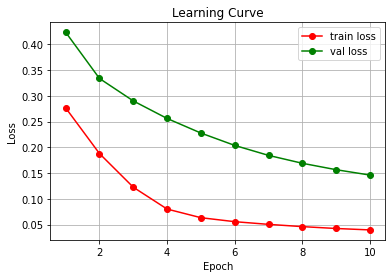

In [16]:
model.plot_learning_curve()

### 【問題8】（アドバンス課題）誤分類の確認


誤分類した画像はどのようなものだったかを確認してください。推定値を用意し、以下のコードを実行してください。

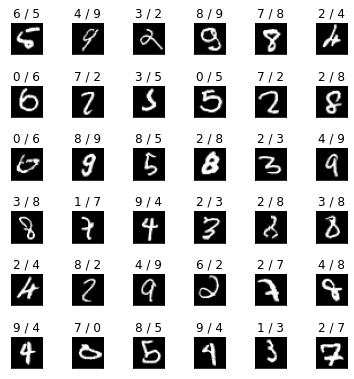

In [20]:
"""
語分類結果を並べて表示する。画像の上の表示は「推定結果/正解」である。

Parameters:
----------
y_pred : 推定値のndarray (n_samples,)
y_test_one_hot : 検証データの正解ラベル(n_samples,)
X_test : 検証データの特徴量（n_samples, n_features)
"""
import numpy as np
import matplotlib.pyplot as plt

num = 36 # いくつ表示するか

true_false = y_pred==y_test
false_list = np.where(true_false==False)[0].astype(np.int)

if false_list.shape[0] < num:
    num = false_list.shape[0]
fig = plt.figure(figsize=(6, 6))
fig.subplots_adjust(left=0, right=0.8,  bottom=0, top=0.8, hspace=1, wspace=0.5)
for i in range(num):
    ax = fig.add_subplot(6, 6, i + 1, xticks=[], yticks=[])
    ax.set_title("{} / {}".format(y_pred[false_list[i]],y_test[false_list[i]]))
    ax.imshow(X_test.reshape(-1,28,28)[false_list[i]], cmap='gray')